# this notebook extracts a lot of data from plate models and plots them

In [3]:
import pygplates
import points_in_polygons
import numpy as np
import pandas as pd
import pickle
import os
from mpl_toolkits.basemap import Basemap, shiftgrid
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from create_gpml import create_gpml_regular_long_lat_mesh
from skimage import measure
%matplotlib inline

In [4]:
#load files

basedir = '/Users/Andrew/Documents/PhD/Models'  #set basedir for load
basedir_save = '/Users/Andrew/Documents/PhD/Scripts/Scripts_Output/Python/2017_Rift_SZ_length/' #set basedir for saving

#load COB files
COBterrane_file_410_0 = '%s/Matthews-410-0Ma/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal_EDITED.gpml' % basedir
COBterrane_file_1000_500 = '%s/1000-410_Models/COBs_global_artificial_individual.gpml' % basedir
COBterrane_file_500_410 = '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Matthews_COBs_for_Dom-models.gpml'

#load Neoproterozoic Rifts
input_rifts_with_modelled_additions_failed_rifts = '%s/1000-410_Models/Rifts/Rifts_with_modelled_additions_failed_rifts_PLOTTING.gpml' % basedir

#load Dom Palaeozoic rifts
input_rifts_with_modelled_additions_failed_rifts_PZ = '%s/1000-410_Models/Rifts/Rifts_with_modelled_additions_failed_rifts_PLOTTING_PZ.gpml' % basedir

#load younger rifts
input_phanerozoic_rifts = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/PyGplates_functions/Arc_rift_length_extraction/output_polylines_trimmed.gpml'

#load polygon files
craton_file_1000_500 = '%s/1000-410_Models/Topos_for_plotting/Neoproterozoic_Palaeozoic_Shapes_20170714_new-antarctica.gpml' % basedir
craton_file_500_410 = '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-Land_ASM.gpml'
craton_file_410_0 = '%s/Matthews-410-0Ma/StaticGeometries/Coastlines/Global_coastlines_2015_v1_low_res.gpml' % basedir

#load rotation files
rotation_file_410_250 = '/Applications/GPlates-2.0.0_r18604M/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
rotation_file_250_0 = '%s/Matthews-410-0Ma/Global_EB_250-0Ma_GK07_Matthews_etal.rot' % basedir
rotation_file_1000_500 = '%s/1000-410_Models/Topos_for_plotting/1000-410_rotations(finished)_20170621a_north_china-tarim-aus.rot' % basedir
rotation_file_500_410 = '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-Rotation_ASM.rot'

#load topologies
topologies = ['%s/1000-410_Models/Topos_for_plotting/Convergence_20170716.gpml' %basedir,
              '%s/1000-410_Models/Topos_for_plotting/Divergence_20170622.gpml' %basedir,
              '%s/1000-410_Models/Topos_for_plotting/Transforms_20170716.gpml' %basedir,
              '%s/1000-410_Models/Topos_for_plotting/Topologies_20170716.gpml' %basedir]


topologies2 = ['/Applications/GPlates-2.0.0_r18604M/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz']

topologies3 = ['%s/Matthews-410-0Ma/Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_Matthews_etal.gpml' % basedir]

topologies4 = ['/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-Ridges_ASM.gpml',
              '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-Topologies_ASM.gpml',
              '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-Trenches_ASM.gpml',
              '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-Transforms_ASM.gpml',
              '/Users/Andrew/Documents/PhD/Models/Domeier_models/Merge/Domeier-EarlyP-merge-ArbitaryLines_ASM.gpml']


#generate pygplates files for Mer17 models
cobter_1000_500 = pygplates.FeatureCollection(COBterrane_file_1000_500)
rotation_model_1000_500 = pygplates.RotationModel(rotation_file_1000_500)
rifts_1000_500 = pygplates.FeatureCollection(input_rifts_with_modelled_additions_failed_rifts)
cratons_1000_500 = pygplates.FeatureCollection(craton_file_1000_500)

#generate pygplates files for Dom1618 models
cobter_500_410 = pygplates.FeatureCollection(COBterrane_file_500_410)
rotation_model_500_410 = pygplates.RotationModel(rotation_file_500_410)
rifts_500_450 = pygplates.FeatureCollection(input_rifts_with_modelled_additions_failed_rifts_PZ)
rifts_phanerozoic = pygplates.FeatureCollection(input_phanerozoic_rifts)
cratons_500_410 = pygplates.FeatureCollection(craton_file_500_410)


#generate pygpltaes file for Mat16 models
cobter_410_0 = pygplates.FeatureCollection(COBterrane_file_410_0)
rotation_model_410_250 = pygplates.RotationModel(rotation_file_410_250)
rotation_model_250_0 = pygplates.RotationModel(rotation_file_250_0)
cratons_410_0 = pygplates.FeatureCollection(craton_file_410_0)

#generate points for creating supercontinent polygons
multipoints = create_gpml_regular_long_lat_mesh(1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()

#set date line wrapper for plotting maps
date_line_wrapper_crat = pygplates.DateLineWrapper()

In [5]:
#create supercotinent polygons
polygons = []
for feature in cobter_410_0:
    
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

cobter_410_0 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')
#
polygons = []
for feature in cobter_1000_500:

    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_geometry()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

cobter_1000_500 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')

polygons = []
for feature in cobter_500_410:
    #print feature
    for geom in feature.get_geometries():
        polygon = []
        #print feature.get_name()
    
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))

        #print polygon.get_geometry()

        polygons.append(polygon)

cobter_500_410 = pygplates.FeatureCollection(polygons)
#fc.write('pltest.gpmlz')

In [6]:
#this function creates new polygons that are the amalgamation of a series of overlapping polygons
#in order to make 'supercontinent polyogns'
def run_grid_pip(time,points,polygons,rotation_model):
    
    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)
    
    rpolygons = []
    for polygon in reconstructed_polygons:
        #print polygon.get_description()
        #if polygon.get_reconstructed_geometry() == 'PolygonOnSphere':
        if polygon.get_reconstructed_geometry():
            #pri#nt polygon.get_reconstructed_geometry()
            rpolygons.append(polygon.get_reconstructed_geometry())


    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    bi = np.array(zval).reshape(181,361)
    
    return bi

### The following cells are for generating AI compatible files at specific time steps.  The method of plotting arcs is changed from dots to lines to make smaller file sizes

### 250-0 

In [ ]:
%%time
#extract data for 250-0
date_line_wrapper = pygplates.DateLineWrapper(0)

for i,time in enumerate(np.arange(0,260,10)):
    print time
    resolved_topologies = []
    shared_boundary_sections = []
    all_tesselated_shared_sub_segment = []
    continental_arcs = []
    reconstructed_COBs = []
    reconstructed_rifts = []
    reconstructed_cratons = []

    pygplates.resolve_topologies(topologies3, rotation_model_250_0, resolved_topologies, time, shared_boundary_sections)
    pygplates.reconstruct(cobter_410_0, rotation_model_250_0, reconstructed_COBs, time)
    pygplates.reconstruct(rifts_phanerozoic, rotation_model_250_0, reconstructed_rifts, time)
    pygplates.reconstruct(cratons_410_0, rotation_model_250_0, reconstructed_cratons, time)
      
    bi = run_grid_pip(time,points,cobter_410_0,rotation_model_250_0)
    
    contours = measure.find_contours(bi, .5)
    
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3, 0.5, fully_connected='low')

    contour_polygons = []
    cobter_feature_collection = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
        cobter_feature_collection.append(cpf)
        
    
    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=0.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,0], fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 30), labels=[0,0,0,0], fontsize=10)
    ax = plt.gca()

    area_threshold = 500000

    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
            wrapped_polygons_lat = []
            wrapped_polygons_lon = []
            wrapped_polygons = date_line_wrapper.wrap(pg, 1)
            for wrapped_polygon in wrapped_polygons:
                for wrapped_point in wrapped_polygon.get_exterior_points():
                    wrapped_point_lat_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
                    wrapped_polygons_lat.append(wrapped_point.get_latitude())
                    wrapped_polygons_lon.append(wrapped_point.get_longitude())
                     
            x_geom, y_geom = m1(wrapped_polygons_lon, wrapped_polygons_lat)
            m1.plot(x_geom, y_geom, '#84a79f', linewidth=2, zorder=0)
            plt.fill(x_geom, y_geom, '#84a79f', edgecolor='r', fill=True, alpha=0.7, zorder=0)
            
    for crat in reconstructed_cratons:
        crat_geom = pygplates.PolygonOnSphere(crat.get_reconstructed_geometry())
        wrapped_cratons = date_line_wrapper.wrap(crat_geom, 1)
        for wrapped_craton in wrapped_cratons:
            wrapped_cratons_lat = []
            wrapped_cratons_lon = []
            for wrapped_craton_point in wrapped_craton.get_exterior_points():
                wrapped_craton_lat_lon = wrapped_craton_point.get_latitude(), wrapped_craton_point.get_longitude()
                wrapped_cratons_lat.append(wrapped_craton_point.get_latitude())
                wrapped_cratons_lon.append(wrapped_craton_point.get_longitude())

            x_geom_crat, y_geom_crat = m1(wrapped_cratons_lon, wrapped_cratons_lat)
            m1.plot(x_geom_crat, y_geom_crat, 'k', linewidth=1,zorder=0)
            plt.fill(x_geom_crat, y_geom_crat, 'k', edgecolor='r', fill=True, alpha=0.2,zorder=0)

    
    # Proximity Test

    distance_kms = 150
    distance_threshold_radians = distance_kms/pygplates.Earth.mean_radius_in_kms
    
    for shared_boundary_section in shared_boundary_sections:

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        mor_lons_plot,mor_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(mor_lons_plot,mor_lats_plot, color='k', linewidth=2, zorder=2)

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        trans_lons_plot,trans_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(trans_lons_plot,trans_lats_plot, color='k', linewidth=1, zorder=2)
                        
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.5))      

                all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)
                
                sz_lons = []
                sz_lats = []
                sz_lons_non = []
                sz_lats_non = []
                for segment in tesselated_shared_sub_segment.get_segments():

                    for pg2 in contour_polygons:

                        if pg2.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
                    
                            pg3 = pg2
                        
                            distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                   pg3,
                                                                                   distance_threshold_radians,
                                                                                   geometry2_is_solid=True)
                           
                            if distance_radians is not None:

                                sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
                                
                            if distance_radians is None:
                                sz_lons_non.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats_non.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
            
                    i = zip(sz_lats, sz_lons)
                    #print i
                    if len(i) > 2:
                        polyline = pygplates.PolylineOnSphere(i)
                        wrapped_polylines = date_line_wrapper.wrap(polyline)
                        for wrapped_polyline in wrapped_polylines:
                            wrapped_point_lat = []
                            wrapped_point_lon = []
                            for wrapped_point in wrapped_polyline.get_points():
                                wrapped_point_lat.append(wrapped_point.get_latitude())
                                wrapped_point_lon.append(wrapped_point.get_longitude())
                                sz_lons_plot,sz_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                                m1.plot(sz_lons_plot,sz_lats_plot, color='#853a2b', linewidth=5, zorder=2)  

                    j = zip(sz_lats_non, sz_lons_non)
                    if len(j) > 2:
                        polyline1 = pygplates.PolylineOnSphere(j)
                        wrapped_polylines1 = date_line_wrapper.wrap(polyline1)
                        for wrapped_polyline1 in wrapped_polylines1:
                            wrapped_point_lat1 = []
                            wrapped_point_lon1 = []
                            for wrapped_point1 in wrapped_polyline1.get_points():
                                wrapped_point_lat1.append(wrapped_point1.get_latitude())
                                wrapped_point_lon1.append(wrapped_point1.get_longitude())
                            sz_lons_plot_non,sz_lats_plot_non = m1(wrapped_point_lon1,wrapped_point_lat1)
                            m1.plot(sz_lons_plot_non,sz_lats_plot_non, color='#4682b4', linewidth=3, zorder=1)            
#
                
    for rift in reconstructed_rifts:
        if (rift.get_feature().get_valid_time()[0] >= time) and (time >= int(rift.get_feature().get_valid_time()[1]) ):
            rift_polyline = rift.get_reconstructed_geometry()
            wrapped_and_tessellated_polylines = date_line_wrapper.wrap(rift_polyline, 0.001)

            rift_lats = []
            rift_lons = [] 
            for wrapped_polyline in wrapped_and_tessellated_polylines:
                for wrapped_point in wrapped_polyline.get_points():

                    rift_lons.append(wrapped_point.get_longitude())
                    rift_lats.append(wrapped_point.get_latitude())
            x_rift,y_rift = m1(rift_lons,rift_lats)
            m1.plot(x_rift,y_rift,color='#d1680e', linewidth=3)

            
    
#Check for existing output directory and create it if not found
    if not os.path.exists('%s/output/snapshots/Figure' % basedir_save):
        os.makedirs('%s/output/snapshots/Figure' % basedir_save)
#
    ##Check for existing output file with same name and remove if found
    if os.path.isfile('%soutput/snapshots/Figure/%s' % (basedir_save, time)):
        os.remove('%soutput/snapshots/Figure/%s' % (basedir_save, time))
        
    plt.savefig('%soutput/snapshots/Figure/%s.png' % (basedir_save, time), bbox_inches='tight', dpi=300)

### 250-410 Ma 

In [ ]:
%%time
#extract data for 410-250
date_line_wrapper = pygplates.DateLineWrapper(0)

for i,time in enumerate(np.arange(260,420,10)):
    print time
    resolved_topologies = []
    shared_boundary_sections = []
    all_tesselated_shared_sub_segment = []
    continental_arcs = []
    reconstructed_COBs = []
    reconstructed_rifts = []
    reconstructed_cratons = []

    pygplates.resolve_topologies(topologies2, rotation_model_410_250, resolved_topologies, time, shared_boundary_sections)
    pygplates.reconstruct(cobter_410_0, rotation_model_410_250, reconstructed_COBs, time)
    pygplates.reconstruct(rifts_phanerozoic, rotation_model_410_250, reconstructed_rifts, time)
    pygplates.reconstruct(cratons_410_0, rotation_model_410_250, reconstructed_cratons, time)
      
    bi = run_grid_pip(time,points,cobter_410_0,rotation_model_410_250)
    
    contours = measure.find_contours(bi, .5)
    
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3, 0.5, fully_connected='low')

    contour_polygons = []
    cobter_feature_collection = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
        cobter_feature_collection.append(cpf)
        
    
    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=0.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,0], fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 30), labels=[0,0,0,0], fontsize=10)
    ax = plt.gca()

    area_threshold = 500000

    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
            wrapped_polygons_lat = []
            wrapped_polygons_lon = []
            wrapped_polygons = date_line_wrapper.wrap(pg, 1)
            for wrapped_polygon in wrapped_polygons:
                for wrapped_point in wrapped_polygon.get_exterior_points():
                    wrapped_point_lat_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
                    wrapped_polygons_lat.append(wrapped_point.get_latitude())
                    wrapped_polygons_lon.append(wrapped_point.get_longitude())
                     
            x_geom, y_geom = m1(wrapped_polygons_lon, wrapped_polygons_lat)
            m1.plot(x_geom, y_geom, '#84a79f', linewidth=2, zorder=0)
            plt.fill(x_geom, y_geom, '#84a79f', edgecolor='r', fill=True, alpha=0.7, zorder=0)
            
    for crat in reconstructed_cratons:
        crat_geom = pygplates.PolygonOnSphere(crat.get_reconstructed_geometry())
        wrapped_cratons = date_line_wrapper.wrap(crat_geom, 1)
        for wrapped_craton in wrapped_cratons:
            wrapped_cratons_lat = []
            wrapped_cratons_lon = []
            for wrapped_craton_point in wrapped_craton.get_exterior_points():
                wrapped_craton_lat_lon = wrapped_craton_point.get_latitude(), wrapped_craton_point.get_longitude()
                wrapped_cratons_lat.append(wrapped_craton_point.get_latitude())
                wrapped_cratons_lon.append(wrapped_craton_point.get_longitude())

            x_geom_crat, y_geom_crat = m1(wrapped_cratons_lon, wrapped_cratons_lat)
            m1.plot(x_geom_crat, y_geom_crat, 'k', linewidth=1,zorder=0)
            plt.fill(x_geom_crat, y_geom_crat, 'k', edgecolor='r', fill=True, alpha=0.2,zorder=0)

    
    # Proximity Test


    trans_lons = []
    trans_lats = []
    distance_kms = 150
    distance_threshold_radians = distance_kms/pygplates.Earth.mean_radius_in_kms
    
    for shared_boundary_section in shared_boundary_sections:

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
#            
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        mor_lons_plot,mor_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(mor_lons_plot,mor_lats_plot, color='k', linewidth=2, zorder=2)
                        count += 1  

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        trans_lons_plot,trans_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(trans_lons_plot,trans_lats_plot, color='k', linewidth=1, zorder=2)
                        
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.5))      

                all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)
                sz_lons = []
                sz_lats = []
                sz_lons_non = []
                sz_lats_non = []
                for segment in tesselated_shared_sub_segment.get_segments():

                    for pg2 in contour_polygons:

                        if pg2.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:

                            pg3 = pg2

                            distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                   pg3,
                                                                                   distance_threshold_radians,
                                                                                   geometry2_is_solid=True)

                            if distance_radians is not None:

                                sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break

                            if distance_radians is None:
                                sz_lons_non.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats_non.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break

                    i = zip(sz_lats, sz_lons)
                    #print i
                    if len(i) > 2:
                        polyline = pygplates.PolylineOnSphere(i)
                        wrapped_polylines = date_line_wrapper.wrap(polyline)
                        for wrapped_polyline in wrapped_polylines:
                            wrapped_point_lat = []
                            wrapped_point_lon = []
                            for wrapped_point in wrapped_polyline.get_points():
                                wrapped_point_lat.append(wrapped_point.get_latitude())
                                wrapped_point_lon.append(wrapped_point.get_longitude())
                                sz_lons_plot,sz_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                                m1.plot(sz_lons_plot,sz_lats_plot, color='#853a2b', linewidth=5, zorder=2)  

                j = zip(sz_lats_non, sz_lons_non)
                if len(j) > 2:
                    polyline1 = pygplates.PolylineOnSphere(j)
                    wrapped_polylines1 = date_line_wrapper.wrap(polyline1)
                    for wrapped_polyline1 in wrapped_polylines1:
                        wrapped_point_lat1 = []
                        wrapped_point_lon1 = []
                        for wrapped_point1 in wrapped_polyline1.get_points():
                            wrapped_point_lat1.append(wrapped_point1.get_latitude())
                            wrapped_point_lon1.append(wrapped_point1.get_longitude())
                        sz_lons_plot_non,sz_lats_plot_non = m1(wrapped_point_lon1,wrapped_point_lat1)
                        m1.plot(sz_lons_plot_non,sz_lats_plot_non, color='#4682b4', linewidth=3, zorder=1)            


                
    for rift in reconstructed_rifts:
        if (rift.get_feature().get_valid_time()[0] >= time) and (time >= int(rift.get_feature().get_valid_time()[1]) ):
            rift_polyline = rift.get_reconstructed_geometry()
            wrapped_and_tessellated_polylines = date_line_wrapper.wrap(rift_polyline, 0.001)

            rift_lats = []
            rift_lons = [] 
            for wrapped_polyline in wrapped_and_tessellated_polylines:
                for wrapped_point in wrapped_polyline.get_points():

                    rift_lons.append(wrapped_point.get_longitude())
                    rift_lats.append(wrapped_point.get_latitude())
            x_rift,y_rift = m1(rift_lons,rift_lats)
            m1.plot(x_rift,y_rift,color='#d1680e', linewidth=3)

            
    
#Check for existing output directory and create it if not found
    if not os.path.exists('%s/output/snapshots/Figure' % basedir_save):
        os.makedirs('%s/output/snapshots/Figure' % basedir_save)
#
    ##Check for existing output file with same name and remove if found
    if os.path.isfile('%soutput/snapshots/Figure/%s' % (basedir_save, time)):
        os.remove('%soutput/snapshots/Figure/%s' % (basedir_save, time))
        
    plt.savefig('%soutput/snapshots/Figure/%s.png' % (basedir_save, time), bbox_inches='tight', dpi=300)

### 410-500 Ma

In [ ]:
#extract data for 500-410
date_line_wrapper = pygplates.DateLineWrapper(0)

for i,time in enumerate(np.arange(420,510,10)):
    print time
    resolved_topologies = []
    shared_boundary_sections = []
    all_tesselated_shared_sub_segment = []
    all_tesselated_shared_sub_segment2 = []
    continental_arcs = []
    reconstructed_COBs = []
    reconstructed_rifts_PZ = []
    reconstructed_rifts_PH = []
    reconstructed_cratons = []
    
    pygplates.resolve_topologies(topologies4, rotation_model_500_410, resolved_topologies, time, shared_boundary_sections)
    pygplates.reconstruct(cobter_500_410, rotation_model_500_410, reconstructed_COBs, time)
    pygplates.reconstruct(rifts_500_450, rotation_model_500_410, reconstructed_rifts_PZ, time)
    pygplates.reconstruct(rifts_phanerozoic, rotation_model_500_410, reconstructed_rifts_PH, time)
    pygplates.reconstruct(cratons_500_410, rotation_model_500_410, reconstructed_cratons, time)
    
    bi = run_grid_pip(time,points,cobter_500_410,rotation_model_500_410)
    
    contours = measure.find_contours(bi, .5)
    
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3, 0.5, fully_connected='low')

    contour_polygons = []
    cobter_feature_collection = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
        cobter_feature_collection.append(cpf)
        
    
    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=0.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,0], fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 30), labels=[0,0,0,0], fontsize=10)
    ax = plt.gca()

    area_threshold = 500000

    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
            wrapped_polygons_lat = []
            wrapped_polygons_lon = []
            wrapped_polygons = date_line_wrapper.wrap(pg, 1)
            for wrapped_polygon in wrapped_polygons:
                for wrapped_point in wrapped_polygon.get_exterior_points():
                    wrapped_point_lat_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
                    wrapped_polygons_lat.append(wrapped_point.get_latitude())
                    wrapped_polygons_lon.append(wrapped_point.get_longitude())
                     
            x_geom, y_geom = m1(wrapped_polygons_lon, wrapped_polygons_lat)
            m1.plot(x_geom, y_geom, '#84a79f', linewidth=2, zorder=0)
            plt.fill(x_geom, y_geom, '#84a79f', edgecolor='r', fill=True, alpha=0.7, zorder=0)
            
    for crat in reconstructed_cratons:
        crat_geom = pygplates.PolygonOnSphere(crat.get_reconstructed_geometry())
        wrapped_cratons = date_line_wrapper.wrap(crat_geom, 1)
        for wrapped_craton in wrapped_cratons:
            wrapped_cratons_lat = []
            wrapped_cratons_lon = []
            for wrapped_craton_point in wrapped_craton.get_exterior_points():
                wrapped_craton_lat_lon = wrapped_craton_point.get_latitude(), wrapped_craton_point.get_longitude()
                wrapped_cratons_lat.append(wrapped_craton_point.get_latitude())
                wrapped_cratons_lon.append(wrapped_craton_point.get_longitude())

            x_geom_crat, y_geom_crat = m1(wrapped_cratons_lon, wrapped_cratons_lat)
            m1.plot(x_geom_crat, y_geom_crat, 'k', linewidth=1,zorder=0)
            plt.fill(x_geom_crat, y_geom_crat, 'k', edgecolor='r', fill=True, alpha=0.2,zorder=0)

    
    # Proximity Test


    trans_lons = []
    trans_lats = []
    distance_kms = 150
    distance_threshold_radians = distance_kms/pygplates.Earth.mean_radius_in_kms
    
    for shared_boundary_section in shared_boundary_sections:

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
#            
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        mor_lons_plot,mor_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(mor_lons_plot,mor_lats_plot, color='k', linewidth=2, zorder=2)

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        trans_lons_plot,trans_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(trans_lons_plot,trans_lats_plot, color='k', linewidth=1, zorder=2)
                        
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.5))      

                all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)
                sz_lons = []
                sz_lats = []
                sz_lons_non = []
                sz_lats_non = []
                for segment in tesselated_shared_sub_segment.get_segments():

                    for pg2 in contour_polygons:

                        if pg2.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
                    
                            pg3 = pg2
                        
                            distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                   pg3,
                                                                                   distance_threshold_radians,
                                                                                   geometry2_is_solid=True)
                           
                            if distance_radians is not None:

                                sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
                                
                            if distance_radians is None:
                                sz_lons_non.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats_non.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break

                    i = zip(sz_lats, sz_lons)
                    #print i
                    if len(i) > 2:
                        polyline = pygplates.PolylineOnSphere(i)
                        wrapped_polylines = date_line_wrapper.wrap(polyline)
                        for wrapped_polyline in wrapped_polylines:
                            wrapped_point_lat = []
                            wrapped_point_lon = []
                            for wrapped_point in wrapped_polyline.get_points():
                                wrapped_point_lat.append(wrapped_point.get_latitude())
                                wrapped_point_lon.append(wrapped_point.get_longitude())
                                sz_lons_plot,sz_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                                m1.plot(sz_lons_plot,sz_lats_plot, color='#853a2b', linewidth=5, zorder=2)  

                    j = zip(sz_lats_non, sz_lons_non)
                    if len(j) > 2:
                        polyline1 = pygplates.PolylineOnSphere(j)
                        wrapped_polylines1 = date_line_wrapper.wrap(polyline1)
                        for wrapped_polyline1 in wrapped_polylines1:
                            wrapped_point_lat1 = []
                            wrapped_point_lon1 = []
                            for wrapped_point1 in wrapped_polyline1.get_points():
                                wrapped_point_lat1.append(wrapped_point1.get_latitude())
                                wrapped_point_lon1.append(wrapped_point1.get_longitude())
                            sz_lons_plot_non,sz_lats_plot_non = m1(wrapped_point_lon1,wrapped_point_lat1)
                            m1.plot(sz_lons_plot_non,sz_lats_plot_non, color='#4682b4', linewidth=3, zorder=1)            
 
    rift_lats = []
    rift_lons = [] 
    for rift in reconstructed_rifts_PH:
        if (rift.get_feature().get_valid_time()[0] > time) and (time > int(rift.get_feature().get_valid_time()[1]) ):
            rift_polyline = rift.get_reconstructed_geometry()
            wrapped_and_tessellated_polylines = date_line_wrapper.wrap(rift_polyline, 0.001)
            rift_lats = []
            rift_lons = [] 
            for wrapped_polyline in wrapped_and_tessellated_polylines:
                for wrapped_point in wrapped_polyline.get_points():

                    rift_lons.append(wrapped_point.get_longitude())
                    rift_lats.append(wrapped_point.get_latitude())
            x_rift,y_rift = m1(rift_lons,rift_lats)
            m1.plot(x_rift,y_rift,color='#d1680e', linewidth=3)
            
    for rift in reconstructed_rifts_PZ:
        if (rift.get_feature().get_valid_time()[0] >= time) and (time >= int(rift.get_feature().get_valid_time()[1]) ):
            rift_polyline = rift.get_reconstructed_geometry()
            wrapped_and_tessellated_polylines = date_line_wrapper.wrap(rift_polyline, 0.001)

            rift_lats = []
            rift_lons = [] 
            for wrapped_polyline in wrapped_and_tessellated_polylines:
                for wrapped_point in wrapped_polyline.get_points():

                    rift_lons.append(wrapped_point.get_longitude())
                    rift_lats.append(wrapped_point.get_latitude())
            x_rift,y_rift = m1(rift_lons,rift_lats)
            m1.plot(x_rift,y_rift,color='#d1680e', linewidth=3)

            
    
#Check for existing output directory and create it if not found
    if not os.path.exists('%s/output/snapshots/Figure' % basedir_save):
        os.makedirs('%s/output/snapshots/Figure' % basedir_save)

    #Check for existing output file with same name and remove if found
    if os.path.isfile('%soutput/snapshots/Figure/%s' % (basedir_save, time)):
        os.remove('%soutput/snapshots/Figure/%s' % (basedir_save, time))
        
    plt.savefig('%soutput/snapshots/Figure/%s.png' % (basedir_save, time), bbox_inches='tight', dpi=300)

### 500-1000 Ma

600
700
800
900
1000


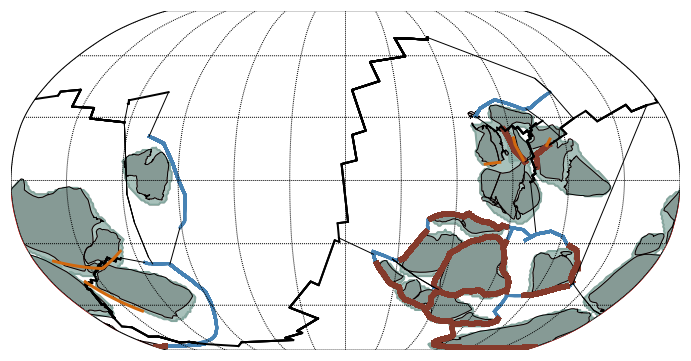

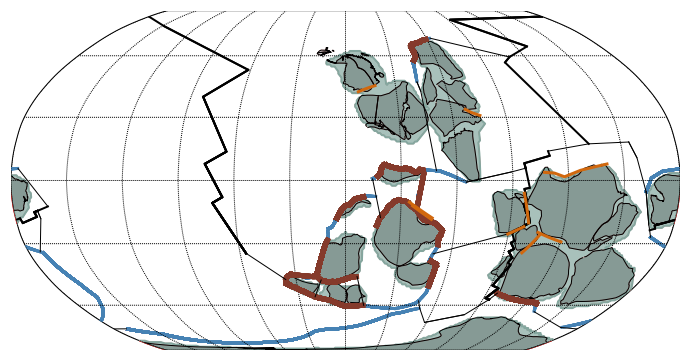

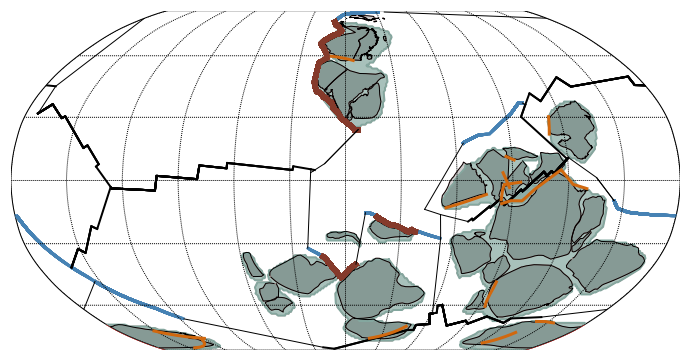

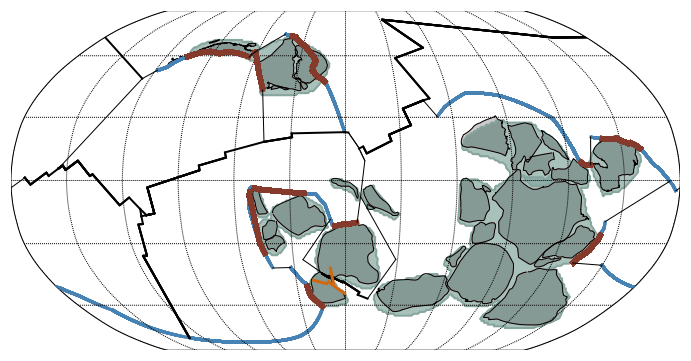

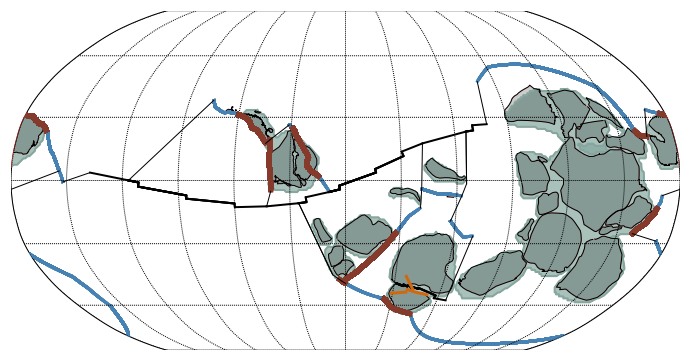

In [8]:
#%%time
#extract data for 1000-510
date_line_wrapper = pygplates.DateLineWrapper(0)

for i,time in enumerate(np.arange(600,1100,100)):
    print time
    resolved_topologies = []
    shared_boundary_sections = []
    continental_arcs = []
    reconstructed_COBs = []
    reconstructed_rifts = []
    reconstructed_cratons = []
    
    pygplates.resolve_topologies(topologies, rotation_model_1000_500, resolved_topologies, time, shared_boundary_sections)
    pygplates.reconstruct(cobter_1000_500, rotation_model_1000_500, reconstructed_COBs, time)
    pygplates.reconstruct(rifts_1000_500, rotation_model_1000_500, reconstructed_rifts, time)
    pygplates.reconstruct(cratons_1000_500, rotation_model_1000_500, reconstructed_cratons, time)
    
    bi = run_grid_pip(time,points,cobter_1000_500,rotation_model_1000_500)
    
    contours = measure.find_contours(bi, .5)
    
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3, 0.5, fully_connected='low')

    contour_polygons = []
    cobter_feature_collection = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
        cobter_feature_collection.append(cpf)
        
    
    fig = plt.figure(figsize=(12,8))
    m1 = Basemap(resolution='c',projection='robin',lon_0=0.)
    clip_path = m1.drawmapboundary()
    m1.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,0], fontsize=10)
    m1.drawparallels(np.arange(-90, 90, 30), labels=[0,0,0,0], fontsize=10)
    ax = plt.gca()

    area_threshold = 500000

    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
            wrapped_polygons_lat = []
            wrapped_polygons_lon = []
            wrapped_polygons = date_line_wrapper.wrap(pg, 1)
            for wrapped_polygon in wrapped_polygons:
                for wrapped_point in wrapped_polygon.get_exterior_points():
                    wrapped_point_lat_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
                    wrapped_polygons_lat.append(wrapped_point.get_latitude())
                    wrapped_polygons_lon.append(wrapped_point.get_longitude())
                     
            x_geom, y_geom = m1(wrapped_polygons_lon, wrapped_polygons_lat)
            m1.plot(x_geom, y_geom, '#84a79f', linewidth=2, zorder=0)
            plt.fill(x_geom, y_geom, '#84a79f', edgecolor='r', fill=True, alpha=0.7, zorder=0)
            
    for crat in reconstructed_cratons:
        crat_geom = pygplates.PolygonOnSphere(crat.get_reconstructed_geometry())
        wrapped_cratons = date_line_wrapper.wrap(crat_geom, 1)
        for wrapped_craton in wrapped_cratons:
            wrapped_cratons_lat = []
            wrapped_cratons_lon = []
            for wrapped_craton_point in wrapped_craton.get_exterior_points():
                wrapped_craton_lat_lon = wrapped_craton_point.get_latitude(), wrapped_craton_point.get_longitude()
                wrapped_cratons_lat.append(wrapped_craton_point.get_latitude())
                wrapped_cratons_lon.append(wrapped_craton_point.get_longitude())

            x_geom_crat, y_geom_crat = m1(wrapped_cratons_lon, wrapped_cratons_lat)
            m1.plot(x_geom_crat, y_geom_crat, 'k', linewidth=1,zorder=0)
            plt.fill(x_geom_crat, y_geom_crat, 'k', edgecolor='r', fill=True, alpha=0.2,zorder=0)

    
    # Proximity Test

    distance_kms = 150
    distance_threshold_radians = distance_kms/pygplates.Earth.mean_radius_in_kms
    
    for shared_boundary_section in shared_boundary_sections:
        count = 0
        
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
#            
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        mor_lons_plot,mor_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(mor_lons_plot,mor_lats_plot, color='k', linewidth=2, zorder=2)
                        count += 1  

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    wrapped_point_lat = []
                    wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        wrapped_point_lat.append(wrapped_point.get_latitude())
                        wrapped_point_lon.append(wrapped_point.get_longitude())
                        trans_lons_plot,trans_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                        m1.plot(trans_lons_plot,trans_lats_plot, color='k', linewidth=1, zorder=2)
                        count += 1                                   

       
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:

            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.5))      

                count = 0
                sz_lons = []
                sz_lats = []
                sz_lons_non = []
                sz_lats_non = []
                for segment in tesselated_shared_sub_segment.get_segments():

                    for pg2 in contour_polygons:

                        if pg2.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
                    
                            pg3 = pg2
                        
                            distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                   pg3,
                                                                                   distance_threshold_radians,
                                                                                   geometry2_is_solid=True)
                           
                            if distance_radians is not None:

                                sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
                                
                            if distance_radians is None:
                                sz_lons_non.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                sz_lats_non.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
#
                            count += 1
                           
              
                #sz_lons_plot_non,sz_lats_plot_non = m1(sz_lons_non,sz_lats_non)
                #m1.scatter(sz_lons_plot_non,sz_lats_plot_non, color='#4682b4', s=1)
                    i = zip(sz_lats, sz_lons)
                    #print i
                    if len(i) > 2:
                        polyline = pygplates.PolylineOnSphere(i)
                        wrapped_polylines = date_line_wrapper.wrap(polyline)
                        for wrapped_polyline in wrapped_polylines:
                            wrapped_point_lat = []
                            wrapped_point_lon = []
                            for wrapped_point in wrapped_polyline.get_points():
                                wrapped_point_lat.append(wrapped_point.get_latitude())
                                wrapped_point_lon.append(wrapped_point.get_longitude())
                                sz_lons_plot,sz_lats_plot = m1(wrapped_point_lon,wrapped_point_lat)
                                m1.plot(sz_lons_plot,sz_lats_plot, color='#853a2b', linewidth=5, zorder=2)  

                    j = zip(sz_lats_non, sz_lons_non)
                    if len(j) > 2:
                        polyline1 = pygplates.PolylineOnSphere(j)
                        wrapped_polylines1 = date_line_wrapper.wrap(polyline1)
                        for wrapped_polyline1 in wrapped_polylines1:
                            wrapped_point_lat1 = []
                            wrapped_point_lon1 = []
                            for wrapped_point1 in wrapped_polyline1.get_points():
                                wrapped_point_lat1.append(wrapped_point1.get_latitude())
                                wrapped_point_lon1.append(wrapped_point1.get_longitude())
                            sz_lons_plot_non,sz_lats_plot_non = m1(wrapped_point_lon1,wrapped_point_lat1)
                            m1.plot(sz_lons_plot_non,sz_lats_plot_non, color='#4682b4', linewidth=3, zorder=1)            

#               
    rift_points = []
 
    for rift in reconstructed_rifts:
        if (rift.get_feature().get_valid_time()[0] >= time) and (time >= int(rift.get_feature().get_valid_time()[1]) ):

            rift_polyline = rift.get_reconstructed_geometry()
            wrapped_and_tessellated_polylines = date_line_wrapper.wrap(rift_polyline, 0.001)

            rift_lats = []
            rift_lons = [] 
            for wrapped_polyline in wrapped_and_tessellated_polylines:
                for wrapped_point in wrapped_polyline.get_points():

                    rift_lons.append(wrapped_point.get_longitude())
                    rift_lats.append(wrapped_point.get_latitude())
            x_rift,y_rift = m1(rift_lons,rift_lats)
            m1.plot(x_rift,y_rift,color='#d1680e', linewidth=3)

            
    
    #Check for existing output directory and create it if not found
    if not os.path.exists('%s/output/snapshots/Figure' % basedir_save):
        os.makedirs('%s/output/snapshots/Figure' % basedir_save)
#
    #Check for existing output file with same name and remove if found
    if os.path.isfile('%soutput/snapshots/Figure/%s' % (basedir_save, time)):
        os.remove('%soutput/snapshots/Figure/%s' % (basedir_save, time))
        
    plt.savefig('%soutput/snapshots/Figure/%s.png' % (basedir_save, time), bbox_inches='tight', dpi=300)